In [1]:
# 0. Imports & Display Settings

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


In [12]:
# 1. Data Loading (Fail-Fast)
# Dynamically find the correct folder for robustness

base_path = '..'
folders = os.listdir(base_path)
print("Folders available in base path:", folders)

correct_folder = next((f for f in folders if f.lower() == 'data'), None)
if correct_folder is None:
    raise FileNotFoundError("No folder named 'Data' found in base path!")

data_path = os.path.join(base_path, correct_folder, 'raw', 'data.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(f"CSV not found at {data_path}")

# Load data
df = pd.read_csv(data_path)
print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
display(df.head())


Folders available in base path: ['.git', '.gitignore', 'Data', 'notebook', 'README.md', 'scr']
Data loaded successfully!
Dataset shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [13]:
# 2. Schema Validation

required_columns = [
    'Amount', 'Value', 'FraudResult',
    'ProductCategory', 'ChannelId', 'ProviderId', 'CurrencyCode',
    'TransactionStartTime'
]

missing = [c for c in required_columns if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print("All required columns are present.")

All required columns are present.



--- Numerical Summary ---
             Amount         Value   FraudResult
count  9.566200e+04  9.566200e+04  95662.000000
mean   6.717846e+03  9.900584e+03      0.002018
std    1.233068e+05  1.231221e+05      0.044872
min   -1.000000e+06  2.000000e+00      0.000000
25%   -5.000000e+01  2.750000e+02      0.000000
50%    1.000000e+03  1.000000e+03      0.000000
75%    2.800000e+03  5.000000e+03      0.000000
max    9.880000e+06  9.880000e+06      1.000000


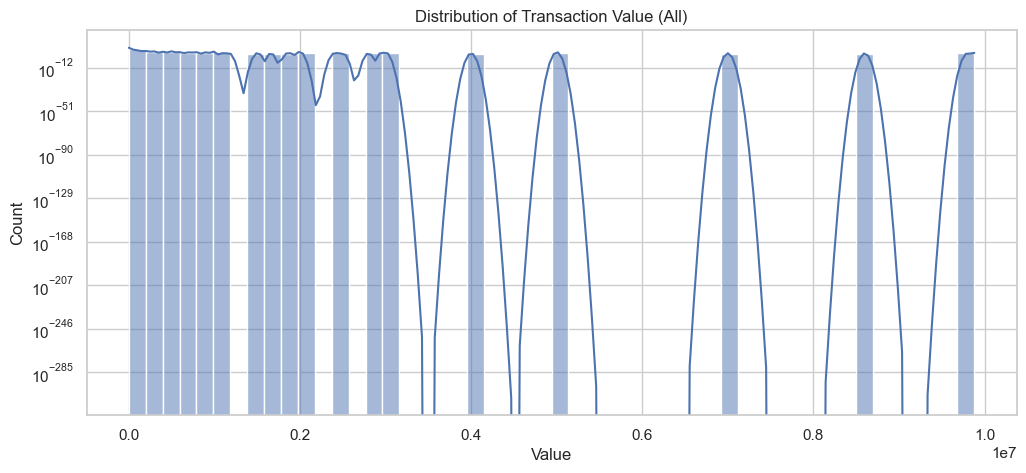

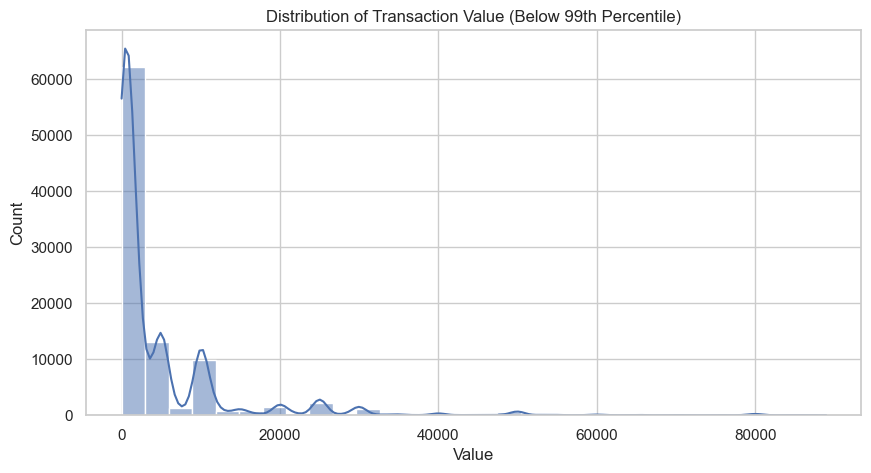

In [14]:
# 3. Numerical Summary & Distribution

numerical_cols = ['Amount', 'Value', 'FraudResult']
print("\n--- Numerical Summary ---")
print(df[numerical_cols].describe())

# Distribution of Value (log scale due to skew)
plt.figure(figsize=(12,5))
sns.histplot(df['Value'], bins=50, kde=True)
plt.title('Distribution of Transaction Value (All)')
plt.yscale('log')
plt.show()

# Focus on 99th percentile
value_q99 = df['Value'].quantile(0.99)
plt.figure(figsize=(10,5))
sns.histplot(df[df['Value'] < value_q99]['Value'], bins=30, kde=True)
plt.title('Distribution of Transaction Value (Below 99th Percentile)')
plt.show()

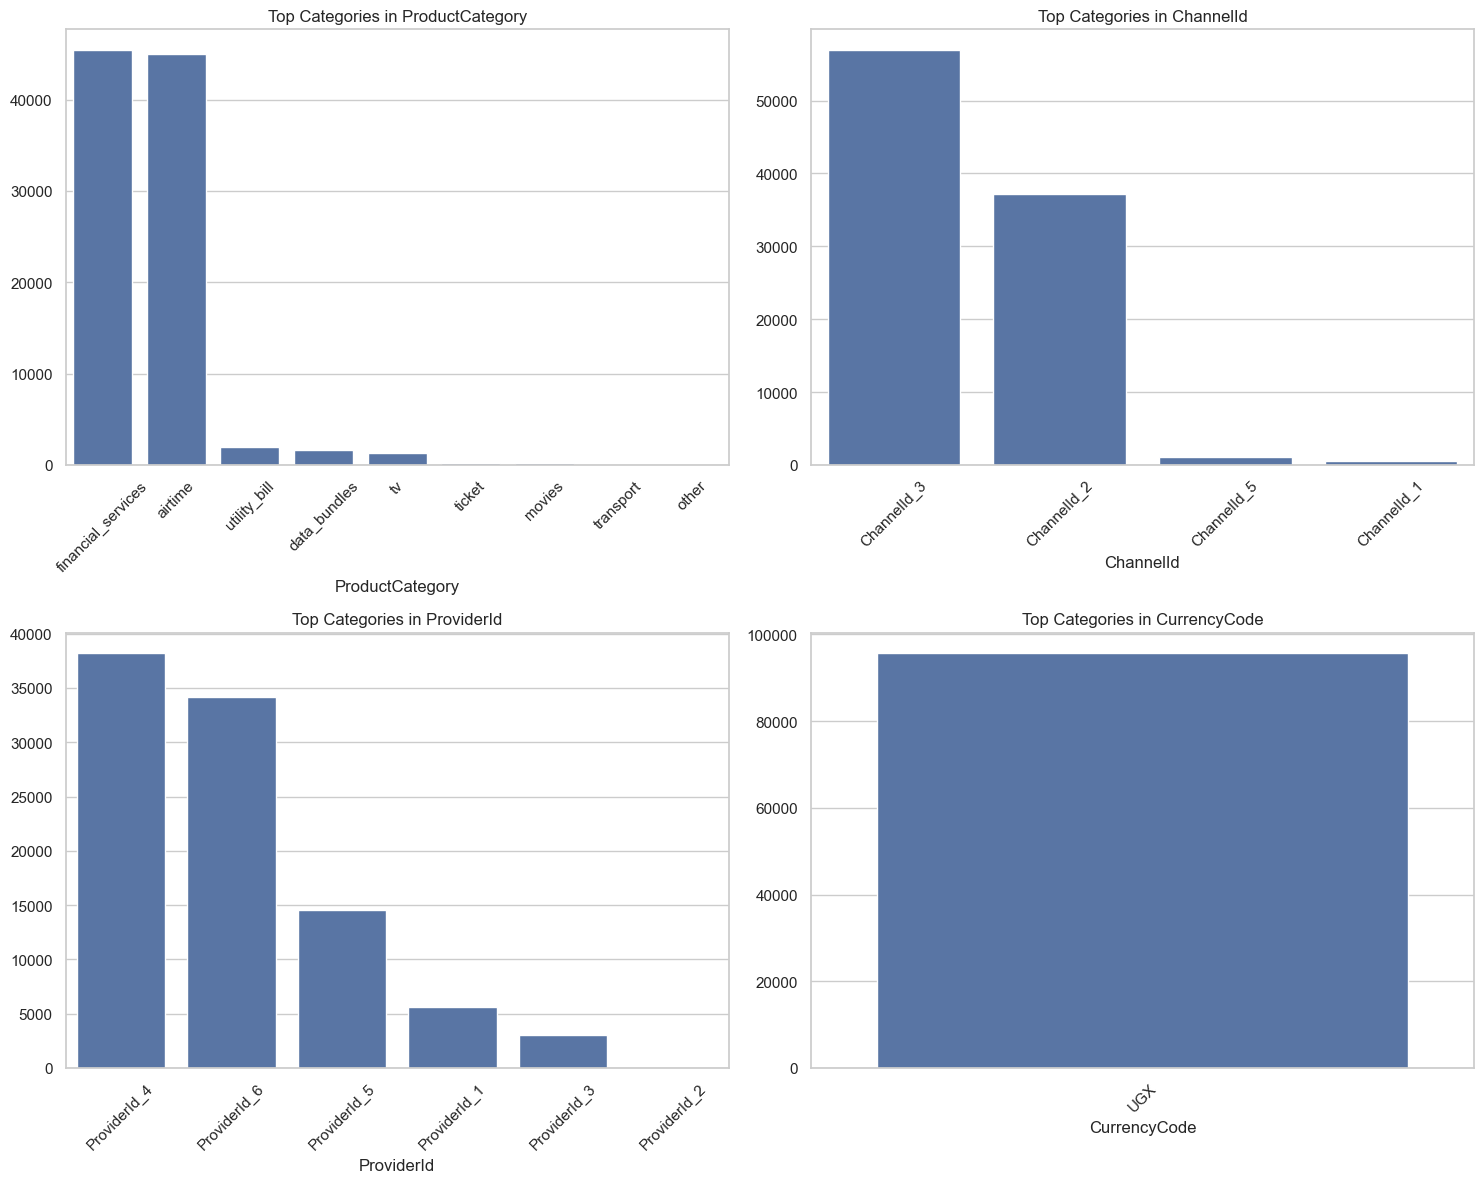

In [15]:
# 4. Categorical Features Distribution

categorical_cols = ['ProductCategory', 'ChannelId', 'ProviderId', 'CurrencyCode']

fig, axes = plt.subplots(2, 2, figsize=(15,12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    top_10 = df[col].value_counts().nlargest(10)
    sns.barplot(x=top_10.index, y=top_10.values, ax=axes[i])
    axes[i].set_title(f'Top Categories in {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused axes if any
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [16]:

# 5. Missing Values & Date Conversion

print("\n--- Missing Value Report ---")
print(df.isnull().sum())

# Convert TransactionStartTime to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
invalid_dates = df['TransactionStartTime'].isna().sum()
print(f"\nInvalid TransactionStartTime entries after conversion: {invalid_dates}")

# ========================================
# 6. Ready for Further Analysis (EDA, RFM, Modeling)
# ========================================

print("\nNotebook is fully loaded and validated. Ready for EDA and modeling tasks.")


--- Missing Value Report ---
TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64

Invalid TransactionStartTime entries after conversion: 0

Notebook is fully loaded and validated. Ready for EDA and modeling tasks.


# 6. Conclusion: Top 3-5 Important Insights

"""
## Key EDA Insights for Feature Engineering

Based on the exploration, the following 3-5 insights will guide the subsequent feature engineering (Task 3 & 4):

1.  **Extreme Skewness and Outliers in Amount/Value:** The `Value` feature is highly right-skewed, with the vast majority of transactions being small, and a few transactions being extreme outliers (confirmed by the log-scale plot and summary statistics).
    * **Action:** Requires robust scaling (e.g., StandardScaler or RobustScaler) or a logarithmic transformation before clustering (RFM) and modeling.

2.  **High Cardinality in AccountId and Transaction Data:** The total number of unique `AccountId`s is very high, confirming the need to aggregate this transactional data *per customer* to create the RFM metrics. The main unit of analysis must shift from the transaction to the customer.
    * **Action:** Focus on customer-level aggregation (Total Amount, Count, Recency) as the primary feature engineering strategy.

3.  **Dominant Categorical Features:** The distribution of features like `ProductCategory` and `ChannelId` shows a few categories (e.g., 'Utility' or a specific `ChannelId`) dominate the transaction volume.
    * **Action:** These dominant categories should be one-hot encoded, but low-frequency categories should be grouped (e.g., 'Other') to avoid too many sparse features.

4.  **No Critical Missing Data:** Initial inspection shows no major missing values in key numerical columns (`Amount`, `Value`). The focus should be on clean processing rather than complex imputation strategies.
"""